# Демонстрация автоматического расчета PDP

In [1]:
import pdpbox
print(pdpbox.__version__)

0.2.1


In [2]:
# расширяем поле, убираем предупреждения
from IPython.core.display import display, HTML
display(HTML('<style>.container {width:95% !important;}</style>'))

import warnings
warnings.filterwarnings('ignore')

In [3]:
# Стандартные библиотеки для анализа
import pandas as pd

from sklearn.model_selection import train_test_split, StratifiedKFold
from sklearn.impute import SimpleImputer

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer

import xgboost as xgb

import matplotlib.pylab as pl

In [4]:
import sys
sys.path.append('../')

# Наша разработанная библиотека
from autobinary import SentColumns, CatBoostEncoder, PlotShap, PlotPDP, BalanceCover, base_pipe

* sklearn:  0.24.2
* xgboost:  1.5.2
* matplotlib:  3.1.1
* autobinary:  1.0.3

In [5]:
import sklearn as sk
import xgboost as xgb
import matplotlib as mplot
import autobinary as ab

print('sklearn: ', sk.__version__)
print('xgboost: ', xgb.__version__)
print('matplotlib: ', mplot.__version__)
print('autobinary: ', ab.__version__)

sklearn:  0.24.2
xgboost:  1.5.2
matplotlib:  3.1.0
autobinary:  1.0.4


In [6]:
sample = pd.read_csv('../data/train_titanic.csv')

print('Размерность данных:', sample.shape)
sample.head(2)

Размерность данных: (891, 12)


,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C


In [7]:
num_columns = [
    'Age', 'Fare'
]

cat_columns = [
    'Pclass', 'Sex', 'Embarked', 'SibSp', 'Parch'
]

target = ['Survived']

In [8]:
X_train, X_valid, y_train, y_valid = train_test_split(
    sample,
    sample[target],
    test_size=0.3,
    stratify=sample[target],
    random_state=42
)

In [9]:
prep_pipe = base_pipe(
    num_columns=num_columns, 
    cat_columns=cat_columns, 
    kind='all')

In [10]:
prep_pipe.fit(X_train, y_train)

new_X_train = prep_pipe.transform(X_train)
new_X_valid = prep_pipe.transform(X_valid)

In [11]:
# создаем экземпляр класса XGBClassifier
xgb_model = xgb.XGBClassifier(
    eta=0.01,
    n_estimators=800,
    subsample=0.9,
    colsample_bytree=0.6,
    max_depth = 6,
    objective='binary:logistic',
    use_label_encoder=False,
    n_jobs=-1,
    random_state=42)

In [12]:
xgb_model.fit(new_X_train, y_train);

[13:07:06] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


## Кастомная метрика

In [13]:
df_train = pd.DataFrame()
df_train['target'] = y_train
df_train['proba'] = xgb_model.predict_proba(new_X_train)[:, 1]
df_train = df_train.sort_values('proba', ascending=False).reset_index(drop=True)

df_valid = pd.DataFrame()
df_valid['target'] = y_valid
df_valid['proba'] = xgb_model.predict_proba(new_X_valid)[:, 1]
df_valid = df_valid.sort_values('proba', ascending=False).reset_index(drop=True)

In [14]:
metr_train = BalanceCover(df_train, target='target')
metr_train.calc_scores(30, df_train.shape[0])

Всего записей в выборке:  623
Всего таргетов в выборке:  239


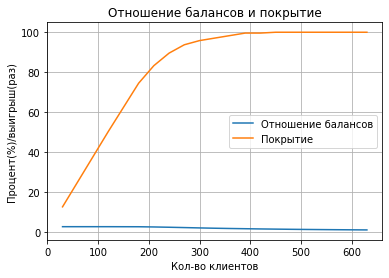

In [15]:
metr_train.sample_describe()
metr_train.plot_scores()

In [16]:
metr_train.output

,start_bucket,end_bucket,turget_in_bucket,bucket_bal (%),coverage (%),base_bal (%),bucket_bal/base_bal
0,0,30,30,100.000000,12.552301,38.362761,2.606695
1,0,60,60,100.000000,25.104603,38.362761,2.606695
2,0,90,90,100.000000,37.656904,38.362761,2.606695
3,0,120,120,100.000000,50.209205,38.362761,2.606695
4,0,150,149,99.333333,62.343096,38.362761,2.589317
5,0,180,178,98.888889,74.476987,38.362761,2.577731
6,0,210,199,94.761905,83.263598,38.362761,2.470153
7,0,240,214,89.166667,89.539749,38.362761,2.324303
8,0,270,224,82.962963,93.723849,38.362761,2.162591
9,0,300,229,76.333333,95.815900,38.362761,1.989777


In [17]:
metr_valid = BalanceCover(df_valid, target='target')
metr_valid.calc_scores(30, df_valid.shape[0])

Всего записей в выборке:  268
Всего таргетов в выборке:  103


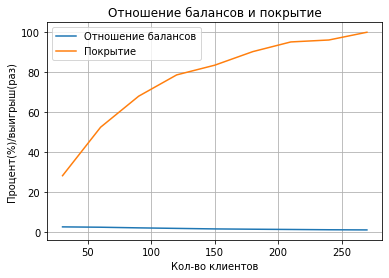

In [18]:
metr_valid.sample_describe()
metr_valid.plot_scores()

In [19]:
metr_valid.output

,start_bucket,end_bucket,turget_in_bucket,bucket_bal (%),coverage (%),base_bal (%),bucket_bal/base_bal
0,0,30,29,96.666667,28.155340,38.432836,2.515210
1,0,60,54,90.000000,52.427184,38.432836,2.341748
2,0,90,70,77.777778,67.961165,38.432836,2.023732
3,0,120,81,67.500000,78.640777,38.432836,1.756311
4,0,150,86,57.333333,83.495146,38.432836,1.491780
5,0,180,93,51.666667,90.291262,38.432836,1.344337
6,0,210,98,46.666667,95.145631,38.432836,1.214239
7,0,240,99,41.250000,96.116505,38.432836,1.073301
8,0,270,103,38.148148,100.000000,38.432836,0.992593


## Использование библиотеки PDP

In [20]:
# Задаем необходимые факторы для анализа, в нужном нам порядке

feats = ['Age','Fare', 'Sex', 'Pclass']

In [21]:
# Задаем класс PlotPDP(model - 'наша модель', 
##                   X - 'датасет на котором обучалась модель',
##                   main_features - 'список факторов необходимых для анализа')

pdp_plot = PlotPDP(model=xgb_model,X=new_X_train,main_features=feats)

Age


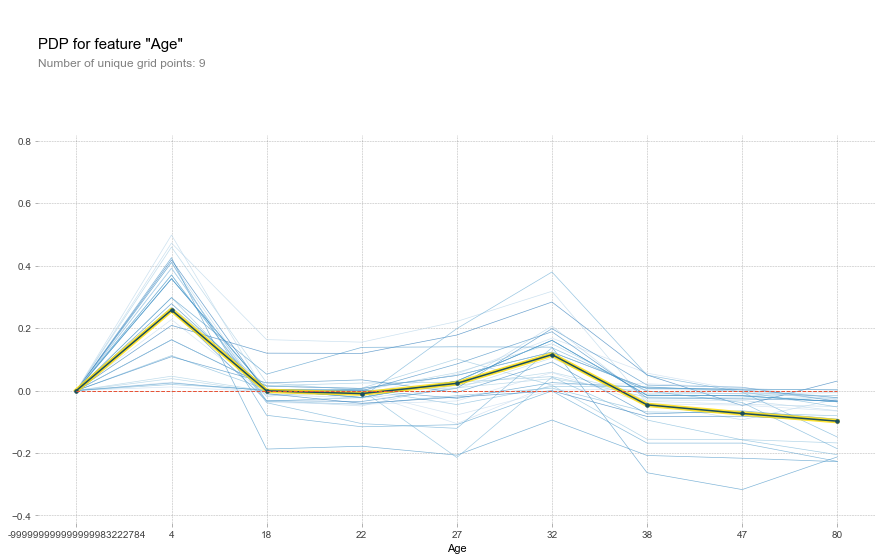

Fare


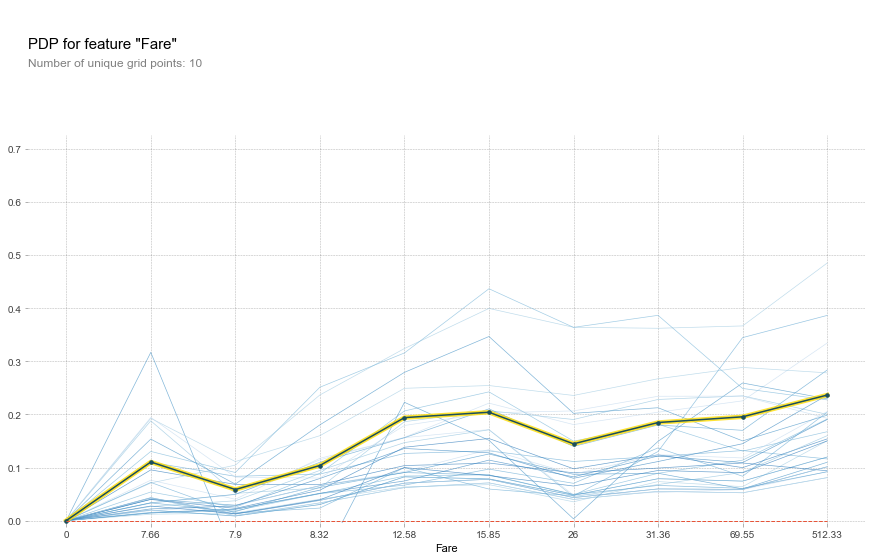

Sex


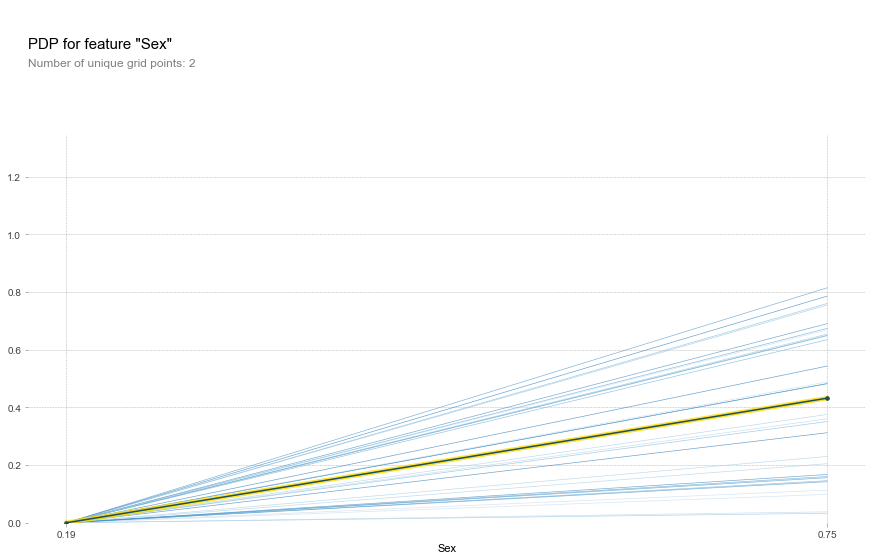

Pclass


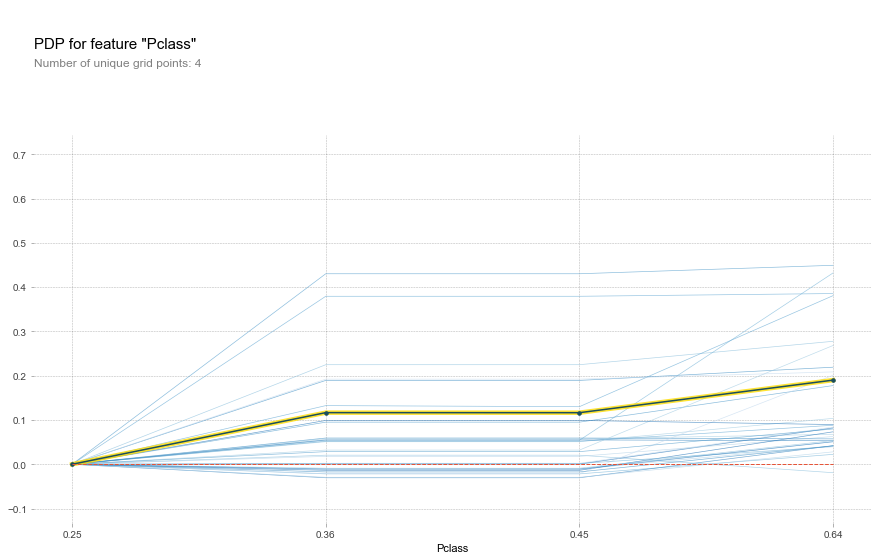

In [22]:
# Выводим графики по каждому фактору функцией create_feature_plot(save = True/False - 'Сохранить/не сохранять графики',
##                                                           frac_to_plot = 0.1 - 'доля сэмпла для анализа, по умолчанию 10%',
##                                                           n_jobs = -1,
##                                                           path = './pdp_ice_plots' - 'директория куда будут сохранены графики')

pdp_plot.create_feature_plot(save=True, frac_to_plot=0.05)

Интерпретация: Как факторы  ['Age', 'Fare'] совместо влияют на предсказание. Чем ярчке (желтая) ячейка, тем сильнее влияние в совокупности: Для классификации - растет вероятность отнесения к целевой метке класса; Для регрессии - растет значение предсказания. Чем темнее (фиолетовая) ячейка - обратная ситуация.


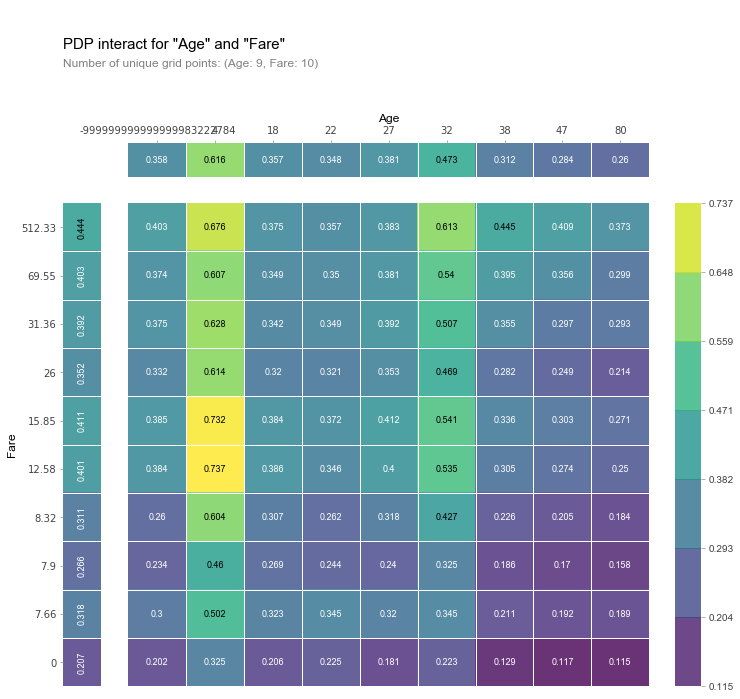

In [23]:
pdp_plot.create_interact_plot(features=['Age','Fare'], save=True)

In [24]:
# Генерация html отчета PDP-ICE plots функцией create_pdp_report(path_base = './pdp_ice_plots' - 'необходимая директория для графиков/отчета')

pdp_plot.create_pdp_report()

Загрузка всех сохраненных изображений 

Загрузка завершена. 

Отчет сгенерирован.


# Проверка на деревьях и линейных моделях / после удалим!

In [25]:
from sklearn.linear_model import LogisticRegression

logreg_clf = LogisticRegression(random_state=42, solver='liblinear')

model_lr = logreg_clf.fit(new_X_train, y_train)

In [26]:
# Задаем класс PlotPDP(model - 'наша модель', 
##                   X - 'датасет на котором обучалась модель',
##                   main_features - 'список факторов необходимых для анализа')

pdp_plot = PlotPDP(model=model_lr,X=new_X_train,main_features=feats)

Age


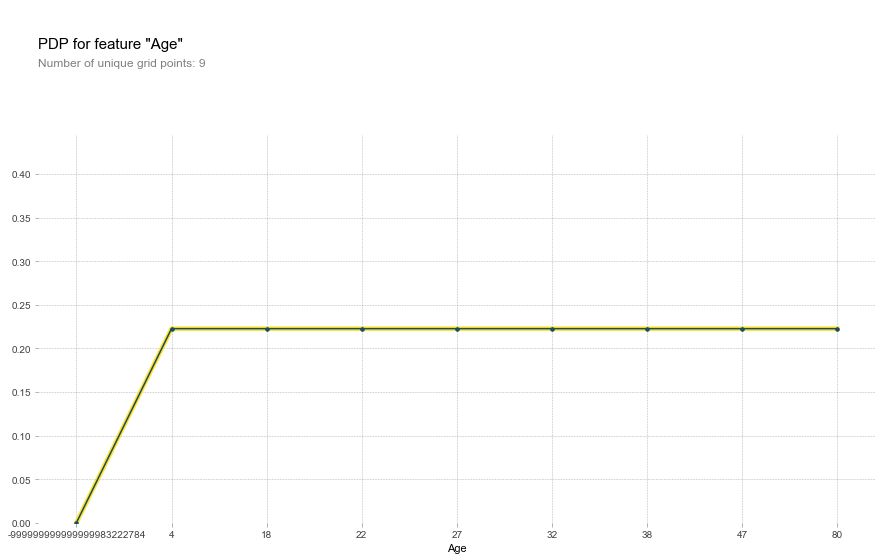

Fare


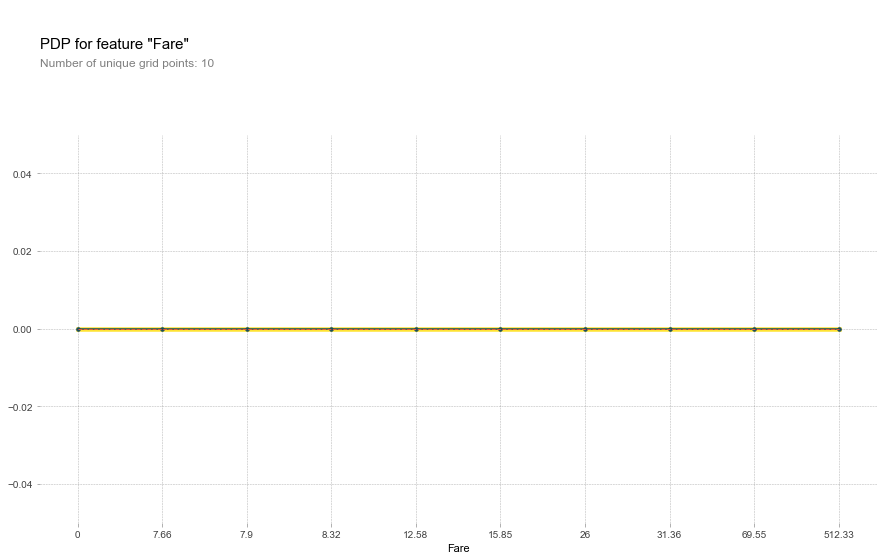

Sex


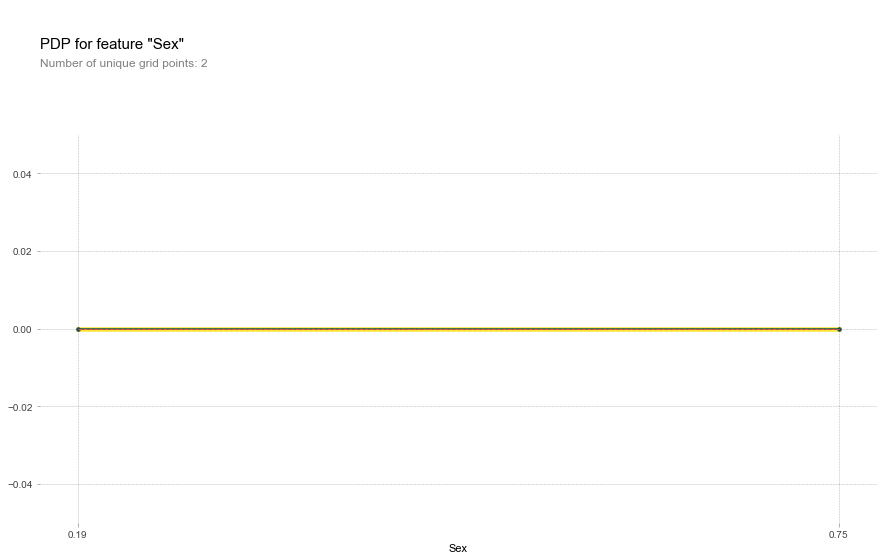

Pclass


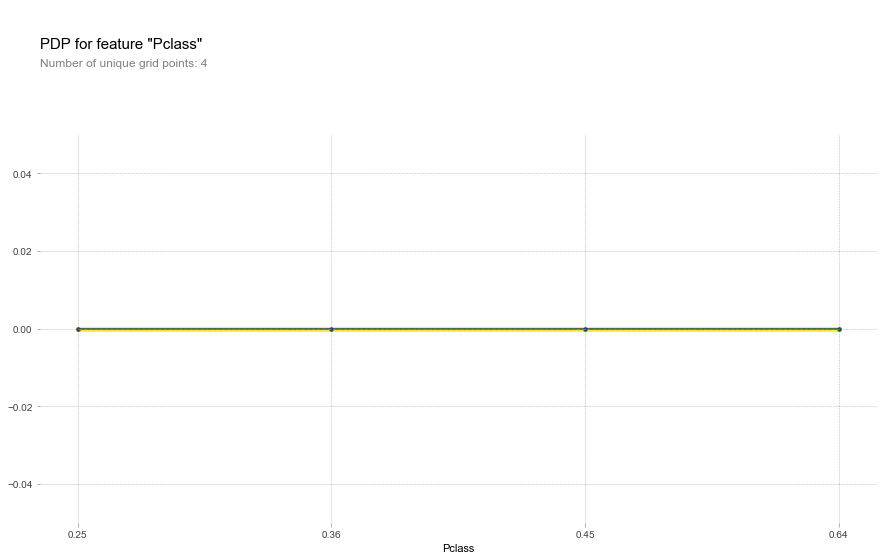

In [27]:
# Выводим графики по каждому фактору функцией create_feature_plot(save = True/False - 'Сохранить/не сохранять графики',
##                                                           frac_to_plot = 0.1 - 'доля сэмпла для анализа, по умолчанию 10%',
##                                                           n_jobs = -1,
##                                                           path = './pdp_ice_plots' - 'директория куда будут сохранены графики')

pdp_plot.create_feature_plot(save=False, frac_to_plot=0.3)

Интерпретация: Как факторы  ['Fare', 'Pclass'] совместо влияют на предсказание. Чем ярчке (желтая) ячейка, тем сильнее влияние в совокупности: Для классификации - растет вероятность отнесения к целевой метке класса; Для регрессии - растет значение предсказания. Чем темнее (фиолетовая) ячейка - обратная ситуация.


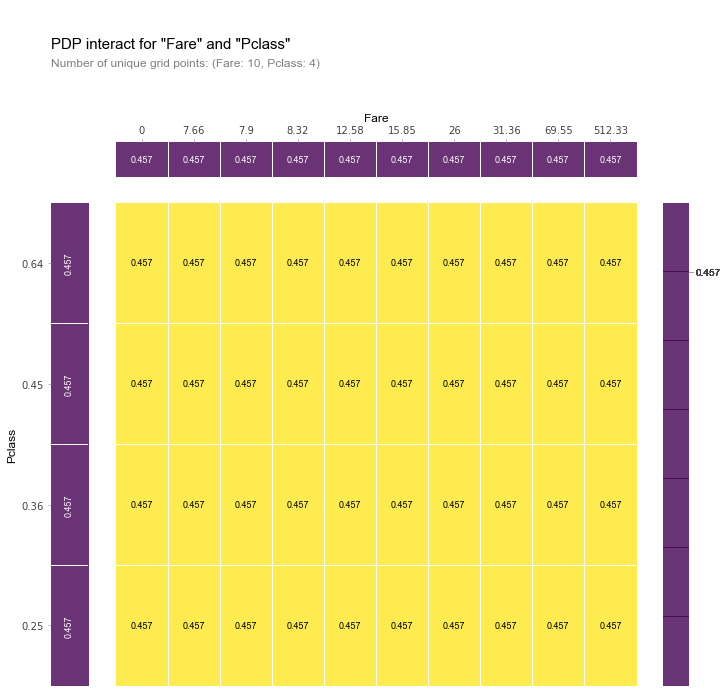

In [28]:
pdp_plot.create_interact_plot(features=['Fare','Pclass'], save=False)

In [29]:
from sklearn.tree import DecisionTreeClassifier

tree_clf = DecisionTreeClassifier(random_state=42)

model_dtree = tree_clf.fit(new_X_train, y_train)

In [30]:
# Задаем класс PlotPDP(model - 'наша модель', 
##                   X - 'датасет на котором обучалась модель',
##                   main_features - 'список факторов необходимых для анализа')

pdp_plot = PlotPDP(model=model_dtree,X=new_X_train,main_features=feats)

Age


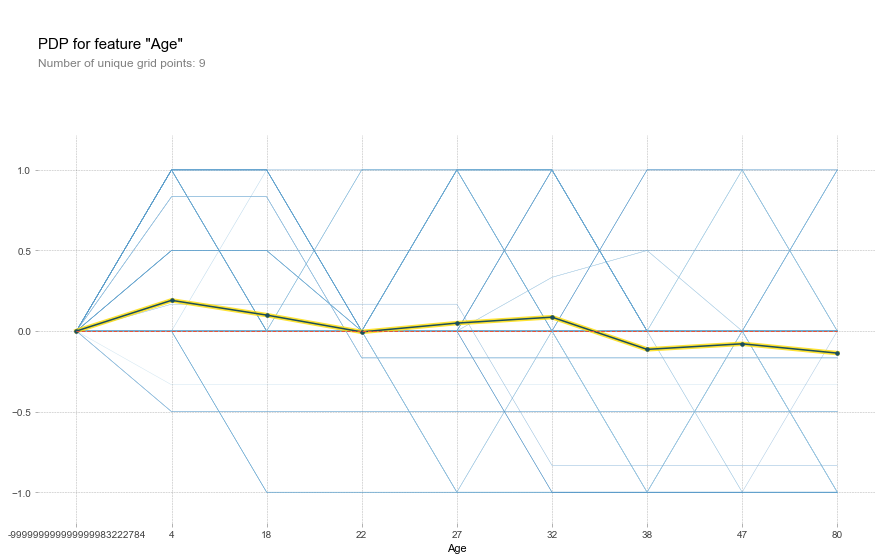

Fare


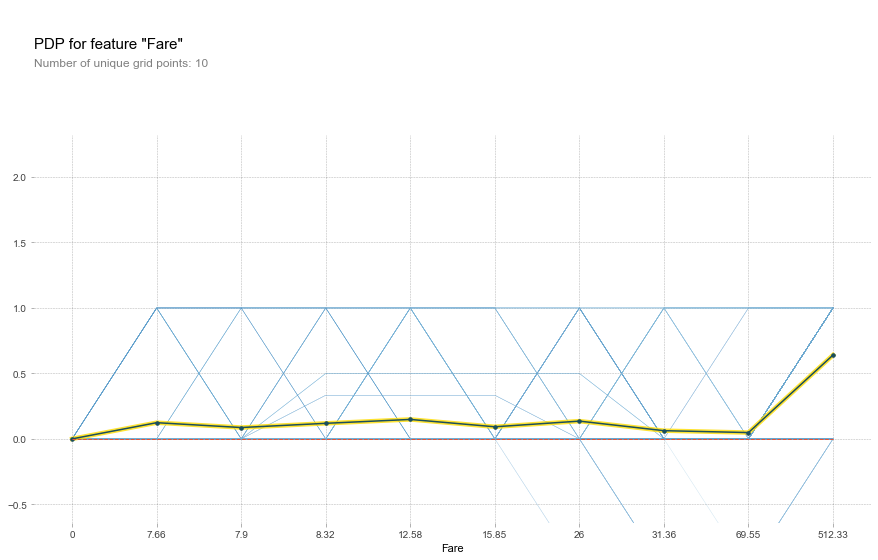

Sex


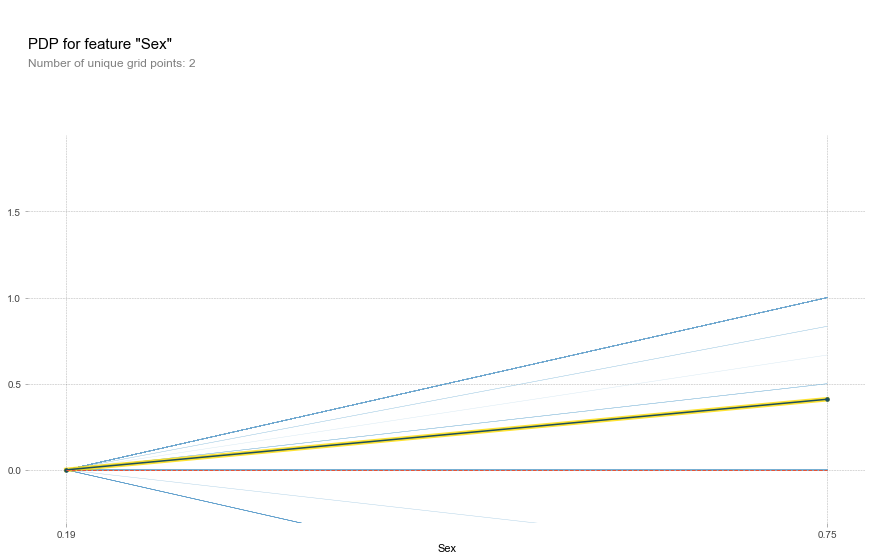

Pclass


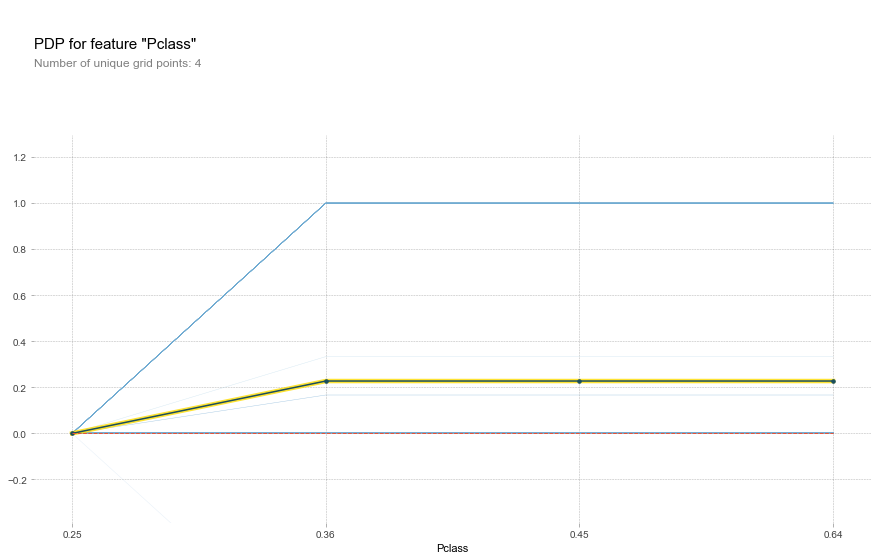

In [31]:
# Выводим графики по каждому фактору функцией create_feature_plot(save = True/False - 'Сохранить/не сохранять графики',
##                                                           frac_to_plot = 0.1 - 'доля сэмпла для анализа, по умолчанию 10%',
##                                                           n_jobs = -1,
##                                                           path = './pdp_ice_plots' - 'директория куда будут сохранены графики')

pdp_plot.create_feature_plot(save=False, frac_to_plot=0.3)

Интерпретация: Как факторы  ['Fare', 'Pclass'] совместо влияют на предсказание. Чем ярчке (желтая) ячейка, тем сильнее влияние в совокупности: Для классификации - растет вероятность отнесения к целевой метке класса; Для регрессии - растет значение предсказания. Чем темнее (фиолетовая) ячейка - обратная ситуация.


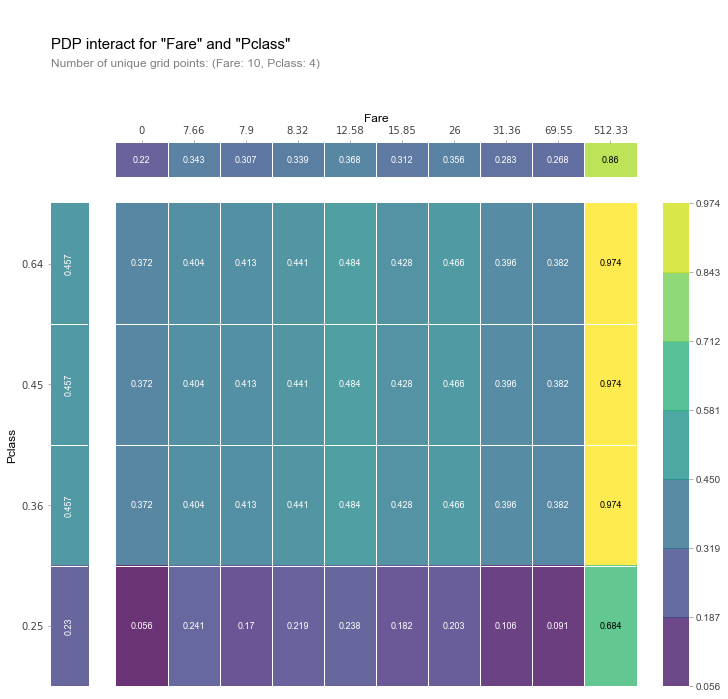

In [32]:
pdp_plot.create_interact_plot(features=['Fare','Pclass'], save=False)

In [33]:
from sklearn.ensemble import RandomForestClassifier

rf_clf = RandomForestClassifier(random_state=42)

model_rf = rf_clf.fit(new_X_train, y_train)

In [34]:
# Задаем класс PlotPDP(model - 'наша модель', 
##                   X - 'датасет на котором обучалась модель',
##                   main_features - 'список факторов необходимых для анализа')

pdp_plot = PlotPDP(model=model_rf,X=new_X_train,main_features=feats)

Age


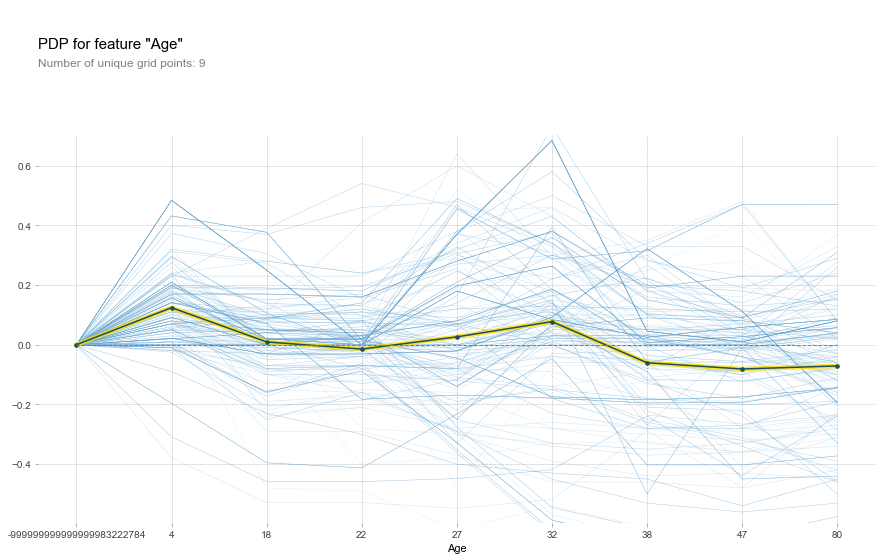

Fare


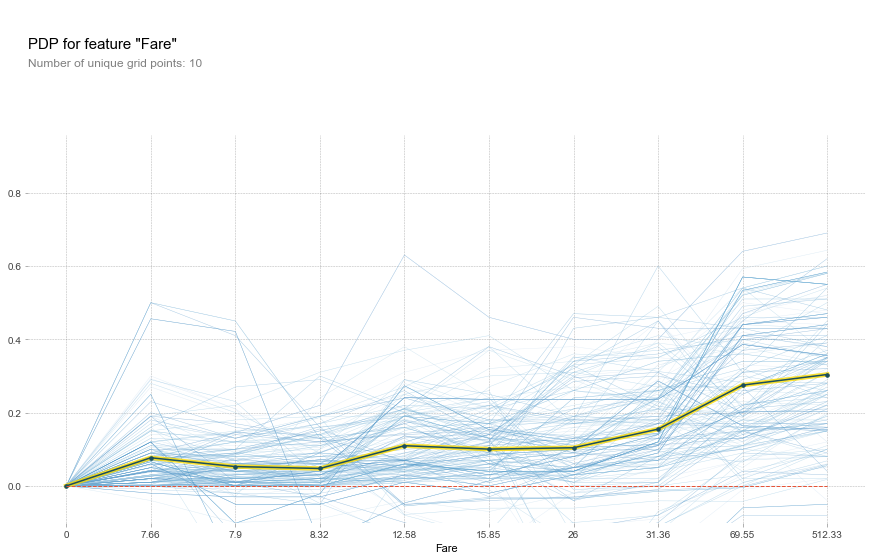

Sex


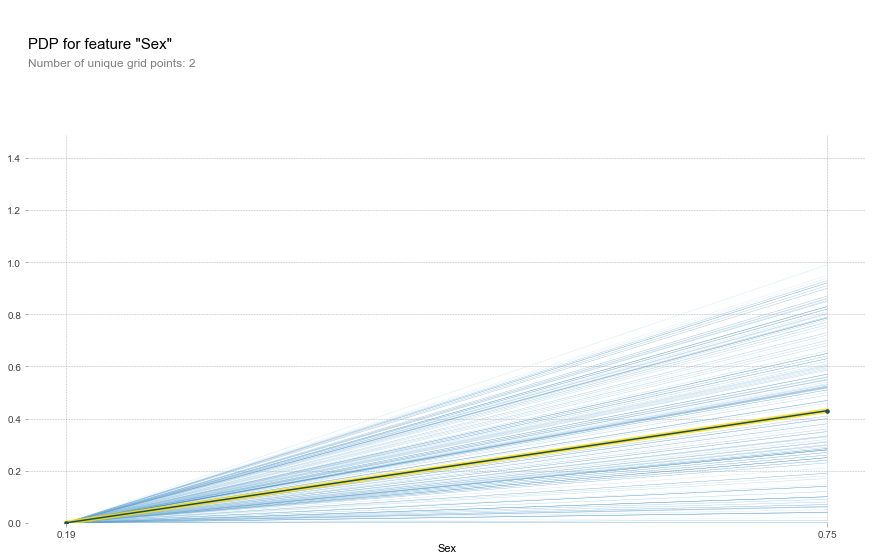

Pclass


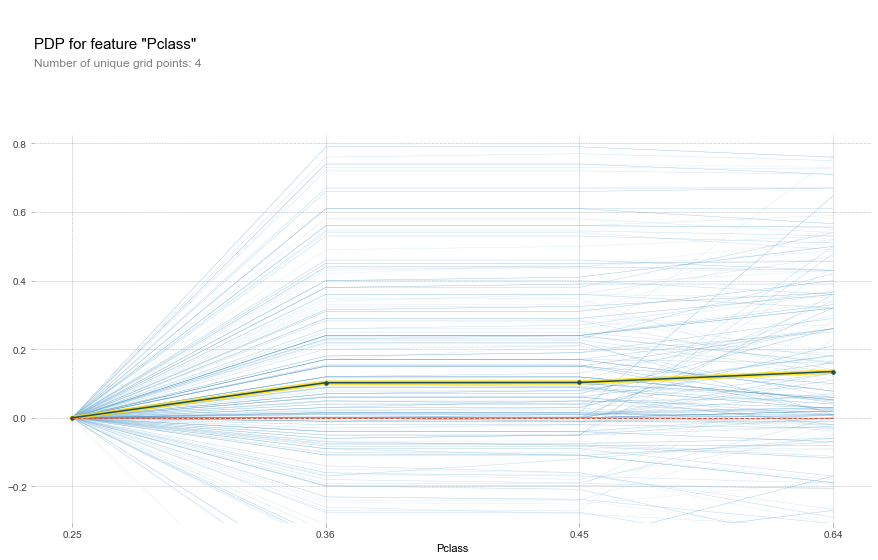

In [35]:
# Выводим графики по каждому фактору функцией create_feature_plot(save = True/False - 'Сохранить/не сохранять графики',
##                                                           frac_to_plot = 0.1 - 'доля сэмпла для анализа, по умолчанию 10%',
##                                                           n_jobs = -1,
##                                                           path = './pdp_ice_plots' - 'директория куда будут сохранены графики')

pdp_plot.create_feature_plot(save=False, frac_to_plot=0.3)

Интерпретация: Как факторы  ['Fare', 'Pclass'] совместо влияют на предсказание. Чем ярчке (желтая) ячейка, тем сильнее влияние в совокупности: Для классификации - растет вероятность отнесения к целевой метке класса; Для регрессии - растет значение предсказания. Чем темнее (фиолетовая) ячейка - обратная ситуация.


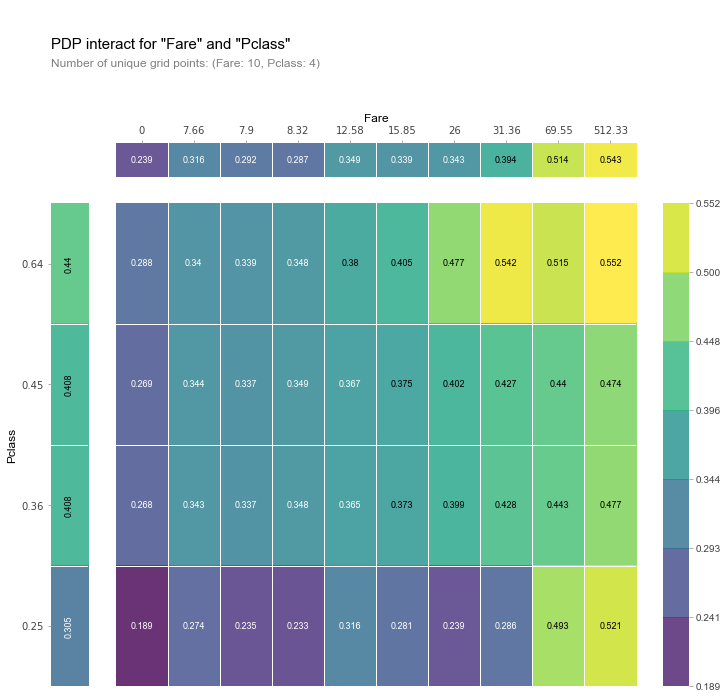

In [36]:
pdp_plot.create_interact_plot(features=['Fare','Pclass'], save=False)